In [1]:
import numpy as np 
import pandas as pd
import os
import re

In [2]:
import matplotlib.pyplot as plt

In [3]:
def Gauss(x, y, z, std_y, std_z, mean_y, mean_z):
    data_x = []
    data_y = []
    data_z = []
    data = []
    for idx_z in z:
        for idx_y in y:
            for i, idx_x in enumerate(x):
                data_x.append(idx_x)
                data_y.append(idx_y)
                data_z.append(idx_z)
                c = 1/(2*np.pi*std_y[i]*std_z[i])*np.exp(-(idx_y-mean_y)**2/(2*std_y[i]**2) - (idx_z-mean_z)**2/(2*std_z[i]**2))
                data.append(c)
    res = []
    res.append(data_x)
    res.append(data_y)
    res.append(data_z)
    res.append(data)
    return res

In [6]:
# data_folder = "for_visualization_05_02_2025/"
data_folder = "output_19_01_2025/"
folder_path_outputs = '/app/nse/outputs/' + data_folder
file_path_results = '/app/nse/results/' + data_folder

In [9]:
x_size = 128
y_size = 128
z_size = 64
x_lenght = 2000
y_width = 2000
z_height = 1000
x_start = 500

In [8]:
def read_data(filename):
    with open(filename, 'r') as file:
        # Skip the first three lines
        for _ in range(3):
            next(file)
        
        # Read the rest of the file
        data = np.loadtxt(file)
    
    return data

In [10]:
def get_folder_paths(folder_path, folder_pattern):
    folder_list = [folder_path + f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f)) and re.search(folder_pattern, f)]
    folder_list.sort(key=os.path.getctime)
    return folder_list

In [11]:
def extract_number(filename):
    match = re.search(r'C\[(\d+)\]-avg-\.plt', filename)
    return int(match.group(1)) if match else float('inf') 

In [12]:
def sort_filenames(filenames):
    return sorted(filenames, key=extract_number)

In [13]:
def get_filenames(file_path, file_pattern):
    file_list = [f for f in os.listdir(file_path) if os.path.isfile(os.path.join(file_path, f)) and re.search(file_pattern, f)]
    file_list = sort_filenames(file_list)
    return file_list

In [14]:
def get_coords_from_np(data, num_coords):
    coords = []
    for i in range(num_coords):
        coord = np.unique(data[:, i])
        coords.append(coord)

    return coords

In [15]:
def get_matrix(data, coords_size):
    return np.reshape(data, coords_size) 

In [16]:
def get_moments_from_1d(slice, coord):
    slice[slice<0]=0
    sl_sum = np.sum(slice)
    if sl_sum != 0:
        slice = np.asarray(slice)/(np.sum(slice))
    mean = np.sum(np.asarray(slice) * np.asarray(coord))
    std_2 = np.sum((np.asarray(coord) - mean) **2 * np.asarray(slice))
    std = np.sqrt(std_2)
    return mean, std

In [17]:
def get_moments_from_2d(slice, coord_1, coord_2):
    slice[slice<0]=0
    slice_2 = np.array([np.sum(s) for s in slice])
    slice_T = np.array(slice).T
    slice_1 = np.array([np.sum(s) for s in slice_T])
    mean_1, std_1 = get_moments_from_1d(slice_1, coord_1)
    mean_2, std_2 = get_moments_from_1d(slice_2, coord_2)
    return mean_1, std_1, mean_2, std_2

In [18]:
def get_slice_from_3d(data, distance, coord_name):
    match coord_name:
        case "x":
            return data[:,:, distance]
        case "y":
            return data[:, distance, :]
        case "z":
            return data[distance, :, :]

In [19]:
def get_slice_from_2d(data, distance, coord_name):
    match coord_name:
        case 1:
            return data[:, distance]
        case 2:
            return data[distance, :]

In [20]:
def get_moments_from_paths_2d(stat_xy_path, stat_xz_path, xy_files, xz_files):
    global x_size, y_size, z_size, x_start
    dist_list = []
    mean_y_list = []
    std_y_list = []
    mean_z_list = []
    std_z_list = []
    
    for i in range(len(xy_files)):
        data_xy = read_data(stat_xy_path + xy_files[i])
        
        data_xz = read_data(stat_xz_path + xz_files[i])
        
        coord_x, coord_y = get_coords_from_np(data_xy, 2)
        coord_x, coord_z = get_coords_from_np(data_xz, 2)

        data_m_xy = get_matrix(data_xy[:, -1], [y_size, x_size]) # y, x
        fig, ax = plt.subplots()
    
    # Create coordinate grids
        grid_1, grid_2 = np.meshgrid(coord_x, coord_y)
        grid_3, grid_4 = np.meshgrid(coord_x, coord_z)
        
        # Create the contour plot
        levels = 50
        contour = ax.contourf(grid_1, grid_2, data_m_xy,
                            levels=levels,
                            extend='both')
        ax.set_yticks(np.linspace(0, np.max(coord_y), 50))
        plt.savefig("xy.png")        
        
        data_m_xz = get_matrix(data_xz[:, -1], [z_size, x_size]) # z, x 
        # contour = ax.contourf(grid_3, grid_4, data_m_xz,
        #                     levels=levels,
        #                     extend='both')
        # plt.savefig("xz.png")
        
        start_idx = np.where(coord_x > x_start)[0][0]
        for idx in range(start_idx, len(coord_x)):
            dist_list.append(coord_x[idx] - x_start)
            slice_y = get_slice_from_2d(data_m_xy, idx, 1)
            slice_z = get_slice_from_2d(data_m_xz, idx, 1)

            mean_y, std_y = get_moments_from_1d(slice_y, coord_y)
            mean_z, std_z = get_moments_from_1d(slice_z, coord_z)
            
            mean_y_list.append(mean_y)
            std_y_list.append(std_y)
            mean_z_list.append(mean_z)
            std_z_list.append(std_z)
    return dist_list, mean_y_list, std_y_list, mean_z_list, std_z_list

In [21]:
def get_moments_from_paths_2d_test(data_xy, data_xz):
    global x_size, y_size, z_size, x_start
    dist_list = []
    mean_y_list = []
    std_y_list = []
    mean_z_list = []
    std_z_list = []
    
    
    coord_x, coord_y = get_coords_from_np(data_xy, 2)
    coord_x, coord_z = get_coords_from_np(data_xz, 2)

    data_m_xy = get_matrix(data_xy[:, -1], [y_size, x_size]) # y, x
    fig, ax = plt.subplots()

# Create coordinate grids
    grid_1, grid_2 = np.meshgrid(coord_x, coord_y)
    grid_3, grid_4 = np.meshgrid(coord_x, coord_z)
    
    # Create the contour plot
    levels = 50
    contour = ax.contourf(grid_1, grid_2, data_m_xy,
                        levels=levels,
                        extend='both')
    ax.set_yticks(np.linspace(0, np.max(coord_y), 50))
    # plt.savefig("xy.png")        
    
    data_m_xz = get_matrix(data_xz[:, -1], [z_size, x_size]) # z, x 
    # contour = ax.contourf(grid_3, grid_4, data_m_xz,
    #                     levels=levels,
    #                     extend='both')
    # plt.savefig("xz.png")
    
    start_idx = np.where(coord_x > x_start)[0][0]
    for idx in range(start_idx, len(coord_x)):
        dist_list.append(coord_x[idx] - x_start)
        slice_y = get_slice_from_2d(data_m_xy, idx, 1)
        slice_z = get_slice_from_2d(data_m_xz, idx, 1)

        mean_y, std_y = get_moments_from_1d(slice_y, coord_y)
        mean_z, std_z = get_moments_from_1d(slice_z, coord_z)
        
        mean_y_list.append(mean_y)
        std_y_list.append(std_y)
        mean_z_list.append(mean_z)
        std_z_list.append(std_z)
    return dist_list, mean_y_list, std_y_list, mean_z_list, std_z_list

In [22]:
def get_moments_from_paths_3d(stat_path, files):
    global x_size, y_size, z_size, x_start
    dist_list = []
    mean_y_list = []
    std_y_list = []
    mean_z_list = []
    std_z_list = []
    
    for i in range(len(files)):
        data = read_data(stat_path + files[i])
        
        coord_x, coord_y, coord_z = get_coords_from_np(data, 3)

        data_m = get_matrix(data[:, -1], [z_size, y_size, x_size]) # z, y, x
        start_idx = np.where(coord_x > x_start)[0][0]
        for idx in range(start_idx, len(coord_x)):
            dist_list.append(coord_x[idx] - x_start)
            slice_yz = get_slice_from_3d(data_m, idx, "x") # z, y

            mean_y, std_y, mean_z, std_z = get_moments_from_2d(slice_yz, coord_y, coord_z)
            
            mean_y_list.append(mean_y)
            std_y_list.append(std_y)
            mean_z_list.append(mean_z)
            std_z_list.append(std_z)
    return dist_list, mean_y_list, std_y_list, mean_z_list, std_z_list

In [23]:
outputs_folder_names = get_folder_paths(folder_path_outputs, "output*")

In [24]:
mean_y_list = []
mean_z_list = []
std_y_list = []
std_z_list = []
distances_list = []

In [28]:
outputs_folder_names[23:24]

['/app/nse/outputs/output_19_01_2025/output_2025_2_11_9_50_15']

In [22]:
# for folder in outputs_folder_names:
#     stat3d_path = folder + "/stat-3d/"
#     stat3d_files = get_filenames(stat3d_path, r'^C\[\d+\]-avg-\.plt$')
#     dist_tmp, mean_y_tmp, std_y_tmp, mean_z_tmp, std_z_tmp = get_moments_from_paths_3d(stat3d_path, stat3d_files)
#     distances_list.extend(dist_tmp)
#     mean_y_list.extend(mean_y_tmp)
#     mean_z_list.extend(mean_z_tmp)
#     std_y_list.extend(std_y_tmp)
#     std_z_list.extend(std_z_tmp)

/app/nse/outputs/output_19_01_2025/output_2025_2_11_9_50_15/stat-2d-XZ/ ['C[1]-avg-.plt']


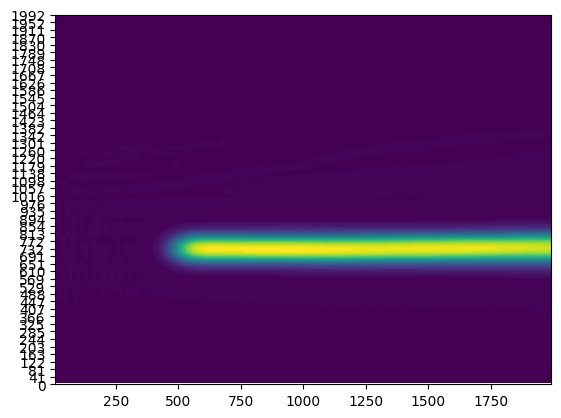

In [29]:
for folder in outputs_folder_names[23:24]:
    stat2d_xy_path = folder + "/stat-2d-XY/"
    stat2d_xy_files = get_filenames(stat2d_xy_path, r'^C\[\d+\]-avg-\.plt$')
    stat2d_xy_files = stat2d_xy_files[1:2]
    stat2d_xz_path = folder + "/stat-2d-XZ/"
    stat2d_xz_files = get_filenames(stat2d_xy_path, r'^C\[\d+\]-avg-\.plt$')
    stat2d_xz_files = stat2d_xz_files[1:2]
    print(stat2d_xz_path, stat2d_xz_files)
    dist_tmp, mean_y_tmp, std_y_tmp, mean_z_tmp, std_z_tmp = get_moments_from_paths_2d(stat2d_xy_path, stat2d_xz_path, stat2d_xy_files, stat2d_xz_files)
    distances_list.extend(dist_tmp)
    mean_y_list.extend(mean_y_tmp)
    mean_z_list.extend(mean_z_tmp)
    std_y_list.extend(std_y_tmp)
    std_z_list.extend(std_z_tmp)

In [30]:
# I_y = 0.88/(np.log(535.0822535184727/0.051296735157090066) - 1)
# I_z = 0.5/(np.log(535.0822535184727/0.051296735157090066) - 1)
I_y = 0.88/(np.log(356/0.053139) - 1)
I_z = 0.5/(np.log(356/0.053139) - 1)
std_y = I_y * np.asarray(distances_list)
std_z = I_z * np.asarray(distances_list)

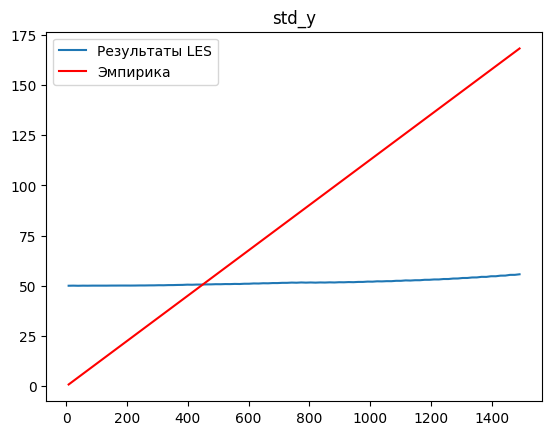

In [31]:
plt.title("std_y")
plt.plot(distances_list, std_y_list, label = "Результаты LES")
plt.plot(distances_list, std_y, "r", label = "Эмпирика")
plt.legend()

In [120]:
np.max(np.abs(std_y - np.asarray(std_y_list)))

49.81216236554132

In [21]:
features_pd = pd.read_csv(file_path_results + "features.csv")
# features_pd["distances"] = distances_list
# features_pd.to_csv(file_path_results + "features.csv")

In [22]:
target_pd = pd.DataFrame({
                        "c_mean_z": mean_z_list,
                        "c_mean_y":mean_y_list, 
                        "c_std_z": std_z_list,
                        "c_std_y": std_y_list})
target_pd.to_csv(file_path_results + "target_full.csv")

In [23]:
num_distances = 96

In [ ]:
plt.scatter(np.ones(num_distances)*features_pd.loc[0, "y"], target_pd["c_mean_y"])
plt.plot(np.ones(num_distances)*features_pd.loc[0, "y"], np.ones(num_distances)*features_pd.loc[0, "y"], "--r")

In [ ]:
features_pd

1329.869770619532

In [ ]:
target_pd

In [ ]:
features_pd = pd.read_csv(file_path_results + "features.csv")
features_full = features_pd.loc(features_pd.index.repeat(num_distances)).reset_index(drop=True)
features_full["distances"] = distances_list
features_full.to_csv("target_full.csv", index=False)

In [ ]:
target_pd["distances"] = distances_list
target_pd["_tmp_index"] = target_pd.index
target_pd_sort = target_pd.sort_values(by=["distances", "_tmp_index"]) 
target_pd_sort = target_pd_sort.drop(columns=["_tmp_index"])

In [ ]:
for dist in np.unique(distances_list):
    tmp_table = target_pd_sort[target_pd_sort.distances == dist].dropna().drop(columns=["distances"])
    tmp_table.to_csv(file_path_results + "target-" + str(dist).replace(".", "_") + ".csv", index=False)

In [26]:
test_x = np.arange(7.8125, 2000, 15.625)
test_y = test_x.copy()
test_z = np.arange(7.8125, 1000, 15.625)

In [46]:
test_std_y = 0.1 * test_x
test_std_z = 0.08 * test_x
test_mean_y = 1000
test_mean_z = 500
x_start=0

In [47]:
test_data = Gauss(test_x, test_y, test_z, test_std_y, test_std_z, test_mean_y, test_mean_z) # x, y, z

In [48]:
test_data = np.array(test_data)
test_data_pd = pd.DataFrame(test_data.T, columns=["x", "y", "z", "c"])

In [49]:
test_data_pd_xy = test_data_pd[['x', 'y', 'c']].groupby(['x', 'y'], sort=False)['c'].sum().reset_index().to_numpy()
test_data_pd_xz = test_data_pd[['x', 'z', 'c']].groupby(['x', 'z'], sort=False)['c'].sum().reset_index().to_numpy()

In [61]:
test_data_pd_0 = test_data_pd[test_data_pd["x"] == 0]

In [63]:
test_data_pd

,x,y,z,c
0,7.8125,7.8125,7.8125,0.000000e+00
1,23.4375,7.8125,7.8125,0.000000e+00
2,39.0625,7.8125,7.8125,0.000000e+00
3,54.6875,7.8125,7.8125,0.000000e+00
4,70.3125,7.8125,7.8125,0.000000e+00
...,...,...,...,...
1048571,1929.6875,1992.1875,992.1875,6.021652e-14
1048572,1945.3125,1992.1875,992.1875,7.941042e-14
1048573,1960.9375,1992.1875,992.1875,1.040082e-13
1048574,1976.5625,1992.1875,992.1875,1.353258e-13


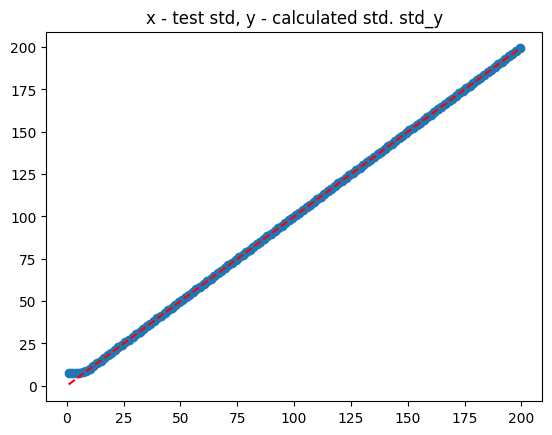

In [53]:
plt.title("x - test std, y - calculated std. std_y")
plt.scatter(test_std_y, std_y_tmp)
plt.plot(test_std_y, test_std_y, "--r")